# INTERSPEECH learning notebook

## Initial toying with model



In [2]:
# Load model directly
from transformers import AutoProcessor, AutoModelForCTC

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-base-960h")

/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import torch
import torchaudio
import subprocess
# Test it on myself

def OBSpreprocessing(file):
    newfilename=file[:-3]+".wav"
    result=subprocess.run(["ffmpeg","-i",file,"-ar","16000",newfilename])
    speech, rate = torchaudio.load(newfilename)
    return speech,rate


In [26]:
speech,rate=OBSpreprocessing("/home/muh2een/testforvai2.mkv")

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/muh2een/miniconda3/envs/voiceai --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
Input #0, matroska,webm, from '/home/muh2een/testforvai2.mkv':
  Metadata:
    ENCODER         : Lavf60.16.100
  Duration: 00:00:03.23, start: 

In [27]:
# Resample the audio if necessary (Wav2Vec 2.0 expects 16 kHz audio)
if rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=rate, new_freq=16000)
    speech = resampler(speech)

# Convert stereo (2 channels) to mono (1 channel) if needed
speech = speech.mean(dim=0)

# Preprocess the audio file (convert it to input values for the model)
input_values = processor(speech.numpy(), rate=16000, return_tensors="pt").input_values

# Perform inference to get logits
with torch.no_grad():
    logits = model(input_values).logits

# Get the predicted IDs from the logits (most likely tokens)
predicted_ids = torch.argmax(logits, dim=-1)

# Decode the predicted IDs to get the transcription
transcription = processor.batch_decode(predicted_ids)[0]

# Print the transcription
print("Transcription:", transcription)
print("Original:", "WOULD YOU LIKE TO GO FOR A WALK")

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Transcription: WOULD YOU LIKE TO GO FOR A WALK
Original: WOULD YOU LIKE TO GO FOR A WALK


In [29]:
speech, rate = torchaudio.load("/home/muh2een/testforvai.wav")
# Resample the audio if necessary (Wav2Vec 2.0 expects 16 kHz audio)
if rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=rate, new_freq=16000)
    speech = resampler(speech)

# Convert stereo (2 channels) to mono (1 channel) if needed
speech = speech.mean(dim=0)

# Preprocess the audio file (convert it to input values for the model)
input_values = processor(speech.numpy(), rate=16000, return_tensors="pt").input_values

# Perform inference to get logits
with torch.no_grad():
    logits = model(input_values).logits

# Get the predicted IDs from the logits (most likely tokens)
predicted_ids = torch.argmax(logits, dim=-1)

# Decode the predicted IDs to get the transcription
transcription = processor.batch_decode(predicted_ids)[0]

# Print the transcription
print("Original:", "Humpty Dumpty sat on a wall, Humpty dumpty had a big fall")
print("Transcription:", transcription)


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Original: Humpty Dumpty sat on a wall, Humpty dumpty had a big fall
Transcription: IMDINUMDE SAT AN ALOR UMDENUMDEN AN A WIG FOR


### Summary of what we learnt (that well eventually go into more detail)
AutoProcessor handles the feature extraction from raw audio (like tokenization for text-based models).
AutoModelForCTC loads the Wav2Vec 2.0 model designed for Connectionist Temporal Classification (CTC), which is commonly used in speech-to-text models.

The audio is loaded using torchaudio, and I used ffmpeg to convert to 16khz.
Audio is converted to mono

The audio waveform is converted into input features using the processor, making it ready for the model.
The model predicts the speech content by generating logits (raw predictions).
The most likely token IDs are selected, and the processor decodes those IDs into human-readable text.(The processor.batch_decode() method converts the model’s output into a readable text format.)

Basically model is working well, and I also learnt that the model ISN'T working well for rhyming (with humpty dumpty example)

Moving on to the actual paper reproduction

***

# Reproducing the paper

`Reproducing INTERSPEECH Paper Results:
Before starting: Make sure you have read the INTERSPEECH paper and understood its motivation, methods, and results. Then, read the papers on Wav2vec 2.0, transfer learning, and data augmentation (these are in the Drive folder). 
For this paper, you will need a GPU and lots of training time. The easiest way is to use the HPCC, that provides over 1TB of storage and access to V100 and T4 GPUs for training. To set up your HPCC account, go to the dashboard at this link to login (https://ondemand.hpcc.msu.edu/). Then, open a terminal to an amd20 or intel16 node. If you are unfamiliar with the HPCC and Linux, it may help to read through these tutorials (https://docs.icer.msu.edu/). Then, in your open terminal, install Anaconda (https://docs.anaconda.com/anaconda/install/) and create a folder to organize your code, models, and datasets.`

Basic stuff already done, HPCC access requested but I do think my RTX 4080 will outperform the HPCC for medium scale learning tasks. 
> Gen-ai : summarise the strength of rtx4080 vs v100 + T4 setup in a short para considering fine tuning deep learnign models

`The RTX 4080 offers superior performance for fine-tuning deep learning models compared to a V100 + T4 setup. With nearly double the CUDA cores of the V100 and 4x more than the T4, alongside 4th-gen Tensor Cores and a more advanced Ada Lovelace architecture, the RTX 4080 excels in raw training speed, making it ideal for tasks like fine-tuning Deep Learning Models. While the V100 is optimized for enterprise workloads and the T4 for efficient inference, the RTX 4080 outperforms both in terms of computational power and efficiency for local model training, though the T4 remains useful for large-scale inference in cloud environments.
`

Theory is rather on the weak end but I'll move forward and try to get something out first asap.


`    1. Download all the videos from FluencyBank online. This can be found here (https://fluency.talkbank.org/access/Voices-AWS.html).
        a. You will want to do this and all other steps on the HPCC. You can read about the HPCC’s file transfer here (https://docs.icer.msu.edu/File_transfer/) or use tools like wget (to download files) and Git (to move code).`

I spent too much time trying to auto wget recursive the data but i'm guessing there is some kind of protection in play, if someone knows how to fix, it would be super nice 
I'm manually downloading files for now(till 29mc was downloaded)

` 2. Parse FluencyBank videos into individual audio file clips based on utterance timestamps in the label.csv file in the shared Drive. This CSV file contains timestamps, ID pointing to the FluencyBank file (based on video name and type, either interview or reading), and the ground-truth text (both with CHAT-annotated disfluencies and without). For this paper, we are using the text without annotated disfluencies. Note that when writing the parsing script, you may want to work locally on your PC, and then transfer your code to the HPCC using Git or ssh (https://docs.icer.msu.edu/Connect_to_HPCC_System/).` 

I dont see any label.csv file, Im assuming the .cha file is what is being referred to

> notes from research on .cha files

`A .cha file is a file format used in the Child Language Data Exchange System (CHILDES) project. It stands for CHAT (Codes for the Human Analysis of Transcripts), which is a format for transcribing and analyzing spoken language, particularly in research focused on child language acquisition, speech disorders, and other linguistic studies.`

In [3]:
import pylangacq

# Load the .cha file 
data = pylangacq.read_chat("/home/muh2een/Downloads/Voices-AWS/interview/24fb.cha")

In [4]:
# Get all utterances

utterances = data.utterances()
for utterance in utterances:
    print(utterance)


Utterance(participant='INV', tokens=[Token(word='please', pos='co', mor='please', gra=Gra(dep=1, head=2, rel='COM')), Token(word='talk', pos='v', mor='talk', gra=Gra(dep=2, head=0, rel='ROOT')), Token(word='about', pos='prep', mor='about', gra=Gra(dep=3, head=2, rel='JCT')), Token(word='the', pos='det:art', mor='the', gra=Gra(dep=4, head=5, rel='DET')), Token(word='impact', pos='n', mor='impact', gra=Gra(dep=5, head=3, rel='POBJ')), Token(word='of', pos='prep', mor='of', gra=Gra(dep=6, head=5, rel='NJCT')), Token(word='stuttering', pos='part', mor='stutter-PRESP', gra=Gra(dep=7, head=6, rel='POBJ')), Token(word='on', pos='prep', mor='on', gra=Gra(dep=8, head=7, rel='JCT')), Token(word='your', pos='det:poss', mor='your', gra=Gra(dep=9, head=11, rel='DET')), Token(word='daily', pos='adj', mor='daily', gra=Gra(dep=10, head=11, rel='MOD')), Token(word='life', pos='n', mor='life', gra=Gra(dep=11, head=8, rel='POBJ')), Token(word='you', pos='pro:per', mor='you', gra=Gra(dep=12, head=14, rel=

#### Update : I found the actual label.csv being referred to, for some reason I did not catch it before

In [5]:
import pandas as pd
labels = pd.read_csv("/home/muh2een/PhD/docs/Our Publications/INTERSPEECH2024/label.csv")

In [6]:
labels

,Audio File ID,Target Text,Coded Lines,Speaker ID,Start Time,End Time
0,reading-32m-11,I don't even know how to say some of these words,&-um I don't even know how to say some of thes...,PAR,1.2,5.00
1,reading-32m-12,so here we are in friuli tucked away in a remo...,so here we are in ↫f:ri:↫f:riuli tucked away i...,PAR,6.3,23.20
2,reading-32m-13,I have to admit that when I travel history is ...,I have to admit that when I travel history is ...,PAR,23.2,28.30
3,reading-32m-14,food and wine are,food and wine are,PAR,28.7,31.60
4,reading-32m-15,and that's what sold me on friuli,and that's what sold me on f≠riuli,PAR,31.6,35.00
...,...,...,...,...,...,...
1373,interview-54f-112,that simple answer.,it's a simple answer but ↫it↫t's what I ↫tr↫tr...,54F,723.6,726.00
1374,interview-54f-113,first of all come to the nsa.,I wouldn't be ↫s-s-s-s↫sitting with you this a...,54F,738.0,741.90
1375,interview-54f-114,I always tell first timers parents it will be ...,and be at this amazing ↫c-c↫conference.,54F,741.9,757.38
1376,interview-54f-115,and that's what I express to them.,whichv [/] which [/] which is my thirteenth.,54F,758.0,764.00


In [7]:
file_names=set()
for label in labels["Audio File ID"].to_list():
    file_names.add(label.split("-")[1])

print("Used files are",file_names)
# BIG ASSUMPTION HERE READING AND INTERVIEW HAVE DIFFERENT ID-S EG: INTERVIEW 54f AND READING 54f DOES NOT EXIST
# VERIFY THIS LATER BUT MAYBE I CAN TAKE THIS FOR GRANTED AND MOVE ON FOR NOW

Used files are {'32m', '29ma', '24mb', '54f', '50fa', '29mc', '24ma', '24fc', '24fa', '35mb', '50fb', '26f'}


#### SPEEDRUNNING : NOT CARING ABOUT PRESENTATION FROM HERE ON OUT, COME BACK AND MAKE NEAT
24mb is a file ive already downloaded and will be my test subject for the day

In [8]:
labels24mb=labels[labels["Audio File ID"].str.contains("interview-24mb")]
labels24mb

,Audio File ID,Target Text,Coded Lines,Speaker ID,Start Time,End Time
274,interview-24mb-12,so can you talk a little bit about the impact ...,so &-um can you talk a little bit about the im...,SP01,0.00,6.45
275,interview-24mb-13,you can talk about family friends education jo...,&-um you can talk about family friends educati...,SP01,6.45,13.10
276,interview-24mb-14,okay so I'm the only person in my family that ...,okay so I'm the only person <in my family> [/]...,SP02,13.10,16.60
277,interview-24mb-15,and for a while stuttering kind of,&-uh and for a while stuttering kind of +//.,SP02,16.60,19.55
278,interview-24mb-16,and stuttering won,and stuttering won,SP02,19.55,20.80
...,...,...,...,...,...,...
376,interview-24mb-114,but help them with their goals and whatever th...,but help them with their goals and whatever th...,SP02,363.20,367.00
377,interview-24mb-115,don't force your agenda on them,&-um don't force your agenda on them,SP02,367.00,370.00
378,interview-24mb-116,let them create their own agenda,↫l↫let them create <the &+agen> [//] their own...,SP02,370.00,372.15
379,interview-24mb-117,and don't follow the textbook,and don't follow the [/] the textbook,SP02,372.15,373.80


In [36]:
labels24mb["Audio File ID"].to_list()

['interview-24mb-12',
 'interview-24mb-13',
 'interview-24mb-14',
 'interview-24mb-15',
 'interview-24mb-16',
 'interview-24mb-17',
 'interview-24mb-18',
 'interview-24mb-19',
 'interview-24mb-20',
 'interview-24mb-21',
 'interview-24mb-22',
 'interview-24mb-23',
 'interview-24mb-24',
 'interview-24mb-25',
 'interview-24mb-26',
 'interview-24mb-27',
 'interview-24mb-28',
 'interview-24mb-29',
 'interview-24mb-30',
 'interview-24mb-31',
 'interview-24mb-32',
 'interview-24mb-33',
 'interview-24mb-34',
 'interview-24mb-35',
 'interview-24mb-36',
 'interview-24mb-37',
 'interview-24mb-38',
 'interview-24mb-39',
 'interview-24mb-40',
 'interview-24mb-41',
 'interview-24mb-42',
 'interview-24mb-43',
 'interview-24mb-44',
 'interview-24mb-45',
 'interview-24mb-46',
 'interview-24mb-47',
 'interview-24mb-48',
 'interview-24mb-49',
 'interview-24mb-50',
 'interview-24mb-51',
 'interview-24mb-52',
 'interview-24mb-53',
 'interview-24mb-54',
 'interview-24mb-55',
 'interview-24mb-56',
 'intervie

## Parsing

I will use ffmpeg to tear apart 24mb

In [37]:
# # test
# import os
# os.path.dirname("/home/muh2een/Downloads/Voices-AWS/interview/24mb.mp4")

In [16]:
import subprocess
import os

def format_time(seconds):
    # Convert seconds to HH:MM:SS.ss format
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return f"{int(h):02}:{int(m):02}:{s:05.2f}"


def extract_segments(file,labels):
    for i in labels.T:
        print(labels.T[i])
        new_filename=f"{os.path.dirname(file)}/{labels.T[i]["Audio File ID"]}.wav"
        command = [
            'ffmpeg', '-i', file,
            '-ss', str(format_time(labels.T[i]["Start Time"])),  # Start time
            '-to', str(format_time(labels.T[i]["End Time"])),    # End time
            '-vn',   # No video
            '-ar', '16000',  # Set audio sample rate to 16kHz (common for speech)
            '-ac', '1',      # Set number of audio channels to mono (1 channel)
            '-f', 'wav',     # Force output format to WAV
            new_filename
        ]


        result = subprocess.run(command, check=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
        if result.returncode != 0:
            print(f"Error: {result.stderr.decode('utf-8')}")


In [17]:
# Pray
extract_segments("/home/muh2een/Downloads/Voices-AWS/interview/24mb.mp4", labels24mb)

Audio File ID                                    interview-24mb-12
Target Text      so can you talk a little bit about the impact ...
Coded Lines      so &-um can you talk a little bit about the im...
Speaker ID                                                    SP01
Start Time                                                     0.0
End Time                                                      6.45
Name: 274, dtype: object
Audio File ID                                    interview-24mb-13
Target Text      you can talk about family friends education jo...
Coded Lines      &-um you can talk about family friends educati...
Speaker ID                                                    SP01
Start Time                                                    6.45
End Time                                                      13.1
Name: 275, dtype: object
Audio File ID                                    interview-24mb-14
Target Text      okay so I'm the only person in my family that ...
Coded Lines 

#### Successful parse, test:

In [18]:
!cd /home/muh2een/Downloads/Voices-AWS/interview; ls |grep 24mb


24mb.cha
24mb.mp4
interview-24mb-100.wav
interview-24mb-101.wav
interview-24mb-102.wav
interview-24mb-103.wav
interview-24mb-104.wav
interview-24mb-105.wav
interview-24mb-106.wav
interview-24mb-107.wav
interview-24mb-108.wav
interview-24mb-109.wav
interview-24mb-110.wav
interview-24mb-111.wav
interview-24mb-112.wav
interview-24mb-113.wav
interview-24mb-114.wav
interview-24mb-115.wav
interview-24mb-116.wav
interview-24mb-117.wav
interview-24mb-118.wav
interview-24mb-12.wav
interview-24mb-13.wav
interview-24mb-14.wav
interview-24mb-15.wav
interview-24mb-16.wav
interview-24mb-17.wav
interview-24mb-18.wav
interview-24mb-19.wav
interview-24mb-20.wav
interview-24mb-21.wav
interview-24mb-22.wav
interview-24mb-23.wav
interview-24mb-24.wav
interview-24mb-25.wav
interview-24mb-26.wav
interview-24mb-27.wav
interview-24mb-28.wav
interview-24mb-29.wav
interview-24mb-30.wav
interview-24mb-31.wav
interview-24mb-32.wav
interview-24mb-33.wav
interview-24mb-34.wav
interview-24mb-35.wav
interview-24mb-36

Working, Great

`3. Next, generate an augmented version of FluencyBank without disfluencies to compare against. Do this by using the SpeechT5 TTS model (https://huggingface.co/blog/speecht5) and randomly selected pre-trained voice vectors (same tutorial linked above), to generate new speech samples of the FluencyBank ground-truth text (that does not contain disfluencies).`

Going through that website and running the tutorial given there for testing

In [19]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

inputs = processor(text="Don't count the days, make the days count.", return_tensors="pt")

from datasets import load_dataset
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")

import torch
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

speaker_embeddings.shape

from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)
speech.shape

from IPython.display import Audio

Audio(speech, rate=16000)

# import soundfile as sf
# sf.write("tts_example.wav", speech.numpy(), samplerate=16000)

/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Attempting to follow instructions now

In [20]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
from datasets import load_dataset
import torch
from transformers import SpeechT5HifiGan
from IPython.display import Audio
import soundfile as sf
import numpy as np

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

for index,row in labels24mb.iterrows():

    inputs = processor(text=row['Target Text'], return_tensors="pt")

    embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
    random_voice__vector = torch.randint(0, len(embeddings_dataset), (1,)).item()  # select random voice vector
    speaker_embeddings = torch.tensor(embeddings_dataset[random_voice__vector]["xvector"]).unsqueeze(0)

    vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
    speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)
    sf.write(f"INTERSPEECH_PARSED/{row["Audio File ID"]}-GEN.wav", speech.numpy(), samplerate=16000)# CORRECT DIRECTORY
    # Audio(speech, rate=16000)



In [52]:
# Test if things are functional

# Things are not functional the code for Parsing is not working as expected!
# UPDATE : previous cade fixed, was not working because ffmpeg did not encode correctly with -c flag, -f wav (force encode wav), it behaved

,Audio File ID,Target Text,Coded Lines,Speaker ID,Start Time,End Time
274,interview-24mb-12,so can you talk a little bit about the impact ...,so &-um can you talk a little bit about the im...,SP01,0.00,6.45
275,interview-24mb-13,you can talk about family friends education jo...,&-um you can talk about family friends educati...,SP01,6.45,13.10
276,interview-24mb-14,okay so I'm the only person in my family that ...,okay so I'm the only person <in my family> [/]...,SP02,13.10,16.60
277,interview-24mb-15,and for a while stuttering kind of,&-uh and for a while stuttering kind of +//.,SP02,16.60,19.55
278,interview-24mb-16,and stuttering won,and stuttering won,SP02,19.55,20.80
...,...,...,...,...,...,...
376,interview-24mb-114,but help them with their goals and whatever th...,but help them with their goals and whatever th...,SP02,363.20,367.00
377,interview-24mb-115,don't force your agenda on them,&-um don't force your agenda on them,SP02,367.00,370.00
378,interview-24mb-116,let them create their own agenda,↫l↫let them create <the &+agen> [//] their own...,SP02,370.00,372.15
379,interview-24mb-117,and don't follow the textbook,and don't follow the [/] the textbook,SP02,372.15,373.80


In [22]:
# Sanity check

import soundfile as sf

original_audio, original_audio_sr = sf.read("/home/muh2een/PhD/INTERSPEECH/interview-24mb-12.wav")
Audio(original_audio,rate=original_audio_sr)


In [23]:
generated_audio, generated_audio_sr = sf.read("/home/muh2een/PhD/INTERSPEECH/interview-24mb-12-GEN.wav")
Audio(generated_audio,rate=generated_audio_sr)

## So far so good, weve successfully generated a voice as per requirements


`    4. Next, to generate augmented samples from FluencyBank for training:
        a. Set up the OpenAI TTS API (https://platform.openai.com/docs/guides/text-to-speech).`

In [9]:
import os

# Quickly check if the environment variable is set for you
api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    print("API key is set.")
else:
    print("API key is not set.")


API key is set.


In [21]:
# # The actual work here is to set up environmental api key, I am assuming whoever is reading has set up environmental api key
# from openai import OpenAI
# from pathlib import Path

# client = OpenAI()

# # speech_file_path = Path(__file__).parent / "speech.mp3"
# response = client.audio.speech.create(
#   model="tts-1",
#   voice="alloy",
#   input="Today is a wonderful day to build something people love!"
# )
# response.stream_to_file("/home/muh2een/PhD/INTERSPEECH/test.wav")

# import soundfile as sf

# test_audio, test_audio_sr = sf.read("/home/muh2een/PhD/INTERSPEECH/test.wav")
# Audio(test_audio,rate=test_audio_sr)

The test was fully functional

Next : `b. Modify text samples in FluencyBank to include disfluencies. Follow the parameters and disfluency types described in the paper.`

Paper says :

```
During training, we augment FluencyBank utterances to as-
sess the impact of incorporating N augmented samples, em-
ploying random sampling from the original dataset with re-
placement. Starting with disfluency-free ground truth tran-
scripts, we introduce specific disfluency events in text form.
These texts are processed by the OpenAI TTS API [27] to syn-
thesize speech with the inserted disfluencies, using voices ran-
domly selected from the OpenAI library. This approach enables
us to simulate a wide range of voices and disfluency events,
along with their occurrence frequency in each utterance, facili-
tating a comprehensive evaluation of ASR performance.
We randomize disfluency frequencies and placements
within set ranges: (1) for word repetition, we select between
1 to 3 words in each utterance to repeat 1 to 4 additional times;
(2) for phrase repetition, we choose a phrase of 2 to 4 words
and repeat it 1 to 3 times; (3) for interjections, we randomly
insert either “uh” or “um” in 1 to 4 locations and repeat them
1 to 4 times. Initially, we explore the effectiveness of adding
N samples during training, for N = 500, 1000, 2000, 3000,
represented as p percent of the original dataset size. Subse-
quently, we change the number of repeats of disfluencies in our
generation approach, and produce up to N = 6000 augmented
samples to assess the impact of increased disfluency variability
on ASR performance. The new ranges used are the following:
(1) for word repetition, each selected word is repeated 1 to 6
additional times; (2) for phrase repetition, each selected phrase
is repeated 1 to 5 additional times; (3) for interjections, each
interjection is repeated 1 to 7 times. The upper bound for all
modification ranges is adjusted to fit the shortest length of the
utterance (e.g., if there are only two words in an utterance, no
more than two disfluency insertions can occur).
```

Take home:
1) take ground truth
2) introduce text disfluencies
    1) for word repetition, we select between 1 to 3 words in each utterance to repeat 1 to 4 additional times
    2) for phrase repetition, we choose a phrase of 2 to 4 words and repeat it 1 to 3 times
    3) for interjections, we randomly insert either “uh” or “um” in 1 to 4 locations and repeat them 1 to 4 times.
3)  process by OpenAI TTS API to synthesize speech with the inserted disfluencies, using voices randomly selected from the OpenAI library

I will introduce ONE disfluency PER sample initially to see how well things are working and will change as required


In [10]:
import random

def add_disfluencies(ground_truths,number_of_disfluencies):
    disfluent_texts=[]

    for sentence in ground_truths:
        words = sentence.split()
        
        for i in range(number_of_disfluencies-1): # Error caught amateur -1 error lol

            disfluency_type = random.choice(['word_repetition', 'phrase_repetition', 'interjection'])
        
            if disfluency_type == 'word_repetition':
                num_repeats = random.randint(1, 3)  # Select between 1 and 3 words to repeat
                for _ in range(num_repeats):
                    word_idx = random.randint(0, len(words) - 1)
                    repetitions = random.randint(1, 4)  # Repeat 1 to 4 additional times
                    words[word_idx:word_idx+1] = [words[word_idx]] * (repetitions + 1)
            
            elif disfluency_type == 'phrase_repetition' and len(words) >= 4:
                if len(words) >= 4:  # Ensure enough words for a phrase
                    phrase_len = random.randint(2, 4)  # Select a phrase of 2 to 4 words
                    start_idx = random.randint(0, len(words) - phrase_len)
                    phrase = words[start_idx:start_idx + phrase_len]
                    repetitions = random.randint(1, 3)  # Repeat the phrase 1 to 3 times
                    words[start_idx:start_idx + phrase_len] = phrase * (repetitions + 1)
            
            elif disfluency_type == 'interjection':
                num_interjections = random.randint(1, 4)  # Insert 1 to 4 interjections
                for _ in range(num_interjections):
                    interjection = random.choice(["uh", "um"])
                    insert_idx = random.randint(0, len(words))
                    repetitions = random.randint(1, 4)  # Repeat the interjection 1 to 4 times
                    words.insert(insert_idx, interjection * repetitions)
        
        # Join the modified words back into a sentence
        disfluent_texts.append(" ".join(words))
    return disfluent_texts


In [11]:
disfluent_24mb=add_disfluencies(labels24mb["Target Text"].to_list(),1)

In [12]:
disfluent_24mb

['so can you talk a little bit about the impact that stuttering has had on your life ?',
 'you can talk about family friends education jobs anything you want',
 "okay so I'm the only person in my family that stutters",
 'and for a while stuttering kind of',
 'and stuttering won',
 'when I was growing up I always questioned am I the only one that stuttered ?',
 'how does this impact future jobs ?',
 "could someone see past the fact that I stutter whether it's a friendship or a relationship or whatever the case may be",
 'but as I got older and did speech therapy and then went back to speech therapy',
 'I gained a sense of acceptance',
 "and know I'm not the only one who stutters",
 'and yes people can see past it',
 'and no it would not affect my job prospects',
 "stuttering doesn't define me as a person",
 'I try not to let it',
 'there are days when it does',
 "but I don't let stuttering define me",
 "and in a way I'm think like I'm glad I stuttered because I don't know where I would 

In [13]:
len(disfluent_24mb)

107

We're going for the OpenAI tts api synth on actual data, RIP dad's credit card

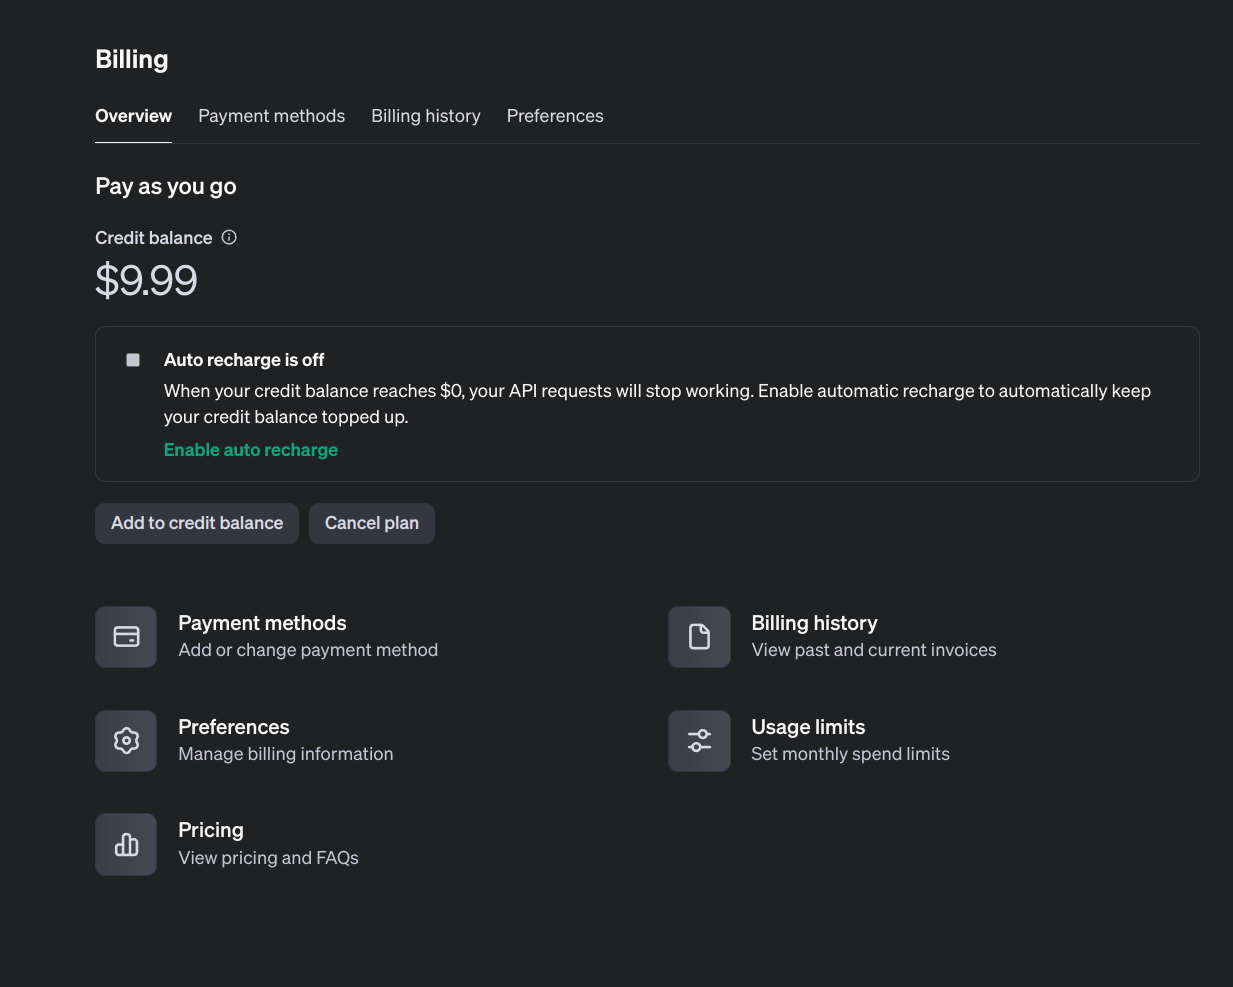

In [14]:
import openai
from pathlib import Path
import random 


index=0
for disfluency in disfluent_24mb:
  voice=random.choice(["alloy", "echo", "fable", "onyx", "nova", "shimmer"])


  response = openai.audio.speech.create(
    model="tts-1",
    voice=voice,
    input=disfluency
  )
  response.stream_to_file(f"/home/muh2een/PhD/INTERSPEECH/24mbOAItts-{index}.wav")
  index+=1

/tmp/ipykernel_34858/1497169698.py:16: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(f"/home/muh2een/PhD/INTERSPEECH/24mbOAItts-{index}.wav")


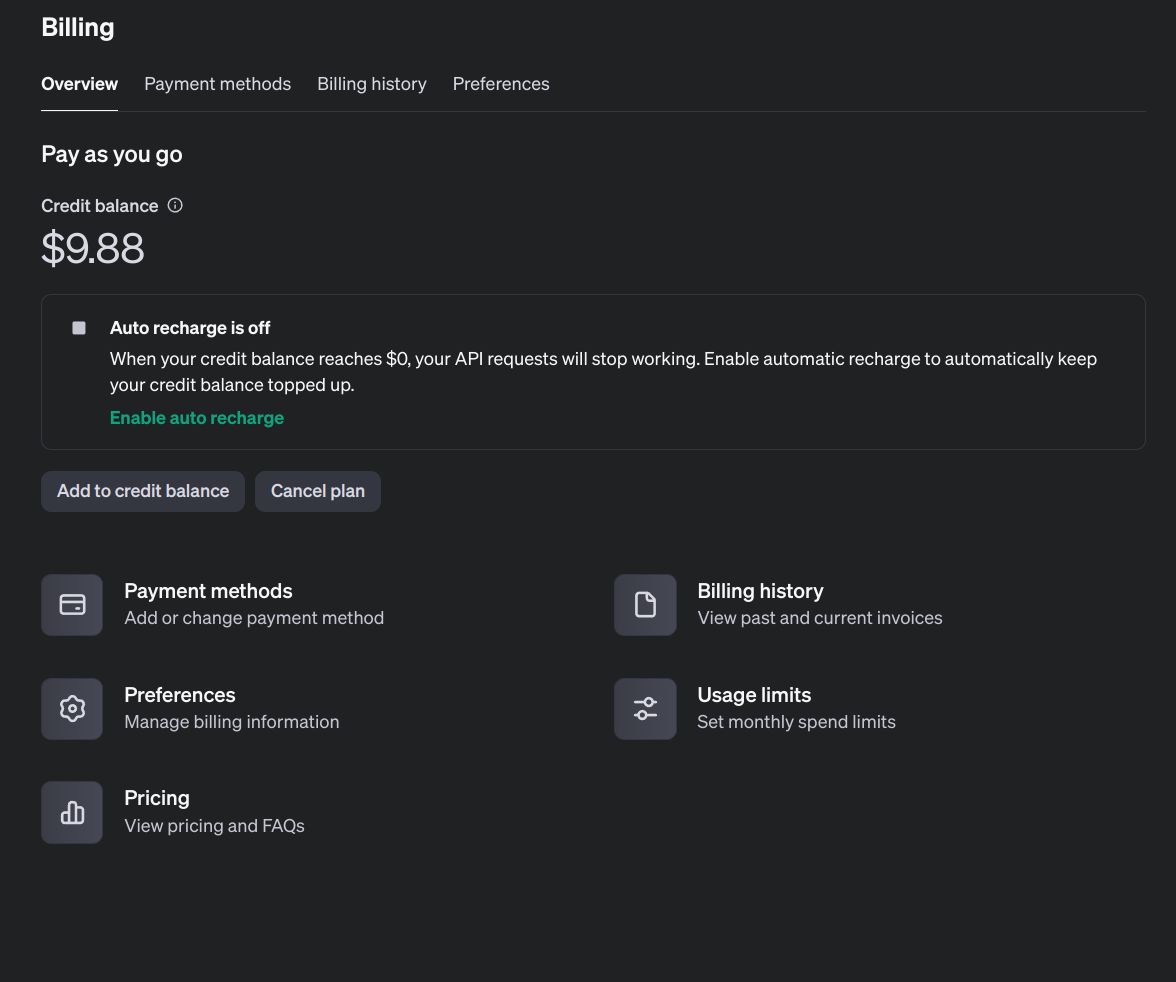

That wasnt too bad at all!

In [16]:
# Sanity checking generated samples
from IPython.display import Audio
import soundfile as sf
test_audio, test_sr = sf.read("/home/muh2een/PhD/INTERSPEECH/24mbOAItts-0.wav")
Audio(test_audio,rate=test_sr)

In [60]:
test_audio, test_sr = sf.read("/home/muh2een/PhD/INTERSPEECH/24mbOAItts-2.wav")
Audio(test_audio,rate=test_sr)

Wow! that's almost impressively good

Let's move on :

```
5. Next, to fine-tune/train the wav2vec2.0 model, you will want to follow the training/testing split and model training parameters followed in the paper. Use the wav2Vec 2.0 model provided by HuggingFace (https://huggingface.co/facebook/wav2vec2-base-960h) and you can follow a procedure similar to this tutorial (https://huggingface.co/blog/fine-tune-wav2vec2-english). After each model is trained, export its predictions on the test set to a csv for analysis later. You will want to do this training on the HPCC using its job scheduling system. You can read about how to run a Python script in a job and request a GPU in the job here (https://docs.icer.msu.edu/Job_Script_and_Job_Submission/). For the wav2vec 2.0 model, you will want to use a V100 GPU, and possibly run simultaneous jobs based on the number of models trained. 
```


I will be running this locally

next steps
1) organise my entire training and test set
2) apparently for ASR models standard is to lowercase and remove  special chars

In [17]:
# My training set is going to be the fluency bank dataset + augmented oai tts stuff
AugData=labels24mb[["Target Text"]]
AugData["FileName"]=[f"24mbOAItts-{i}.wav" for i in range(len(AugData))]
AugData=AugData.reset_index(drop=True) # Reset old crappy indexes
AugData=AugData[["FileName","Target Text"]] # Resetting order for sanity
AugData

/tmp/ipykernel_34858/1890571135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AugData["FileName"]=[f"24mbOAItts-{i}.wav" for i in range(len(AugData))]


,FileName,Target Text
0,24mbOAItts-0.wav,so can you talk a little bit about the impact ...
1,24mbOAItts-1.wav,you can talk about family friends education jo...
2,24mbOAItts-2.wav,okay so I'm the only person in my family that ...
3,24mbOAItts-3.wav,and for a while stuttering kind of
4,24mbOAItts-4.wav,and stuttering won
...,...,...
102,24mbOAItts-102.wav,but help them with their goals and whatever th...
103,24mbOAItts-103.wav,don't force your agenda on them
104,24mbOAItts-104.wav,let them create their own agenda
105,24mbOAItts-105.wav,and don't follow the textbook


In [18]:
# Next lets add the remaining data from labels
Remdata=labels24mb[["Audio File ID","Target Text"]]
Remdata=Remdata.reset_index(drop=True) # Reset old crappy indexes
Remdata = Remdata.rename(columns={'Audio File ID': 'FileName'})
Remdata["FileName"]+=".wav"
Remdata


,FileName,Target Text
0,interview-24mb-12.wav,so can you talk a little bit about the impact ...
1,interview-24mb-13.wav,you can talk about family friends education jo...
2,interview-24mb-14.wav,okay so I'm the only person in my family that ...
3,interview-24mb-15.wav,and for a while stuttering kind of
4,interview-24mb-16.wav,and stuttering won
...,...,...
102,interview-24mb-114.wav,but help them with their goals and whatever th...
103,interview-24mb-115.wav,don't force your agenda on them
104,interview-24mb-116.wav,let them create their own agenda
105,interview-24mb-117.wav,and don't follow the textbook


In [19]:
Data = pd.concat([AugData, Remdata], axis=0)
Data=Data.reset_index(drop=True) # Reset old crappy indexes
Data

,FileName,Target Text
0,24mbOAItts-0.wav,so can you talk a little bit about the impact ...
1,24mbOAItts-1.wav,you can talk about family friends education jo...
2,24mbOAItts-2.wav,okay so I'm the only person in my family that ...
3,24mbOAItts-3.wav,and for a while stuttering kind of
4,24mbOAItts-4.wav,and stuttering won
...,...,...
209,interview-24mb-114.wav,but help them with their goals and whatever th...
210,interview-24mb-115.wav,don't force your agenda on them
211,interview-24mb-116.wav,let them create their own agenda
212,interview-24mb-117.wav,and don't follow the textbook


In [20]:
# The following contains a lot of borrowed code from https://huggingface.co/blog/fine-tune-wav2vec2-english
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(text):
    return re.sub(chars_to_ignore_regex, '', text).lower()



<>:3: SyntaxWarning: invalid escape sequence '\,'
<>:3: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_34858/2414017867.py:3: SyntaxWarning: invalid escape sequence '\,'
  chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'


In [21]:
Data['Target Text'] = Data['Target Text'].apply(remove_special_characters)
Data

,FileName,Target Text
0,24mbOAItts-0.wav,so can you talk a little bit about the impact ...
1,24mbOAItts-1.wav,you can talk about family friends education jo...
2,24mbOAItts-2.wav,okay so i'm the only person in my family that ...
3,24mbOAItts-3.wav,and for a while stuttering kind of
4,24mbOAItts-4.wav,and stuttering won
...,...,...
209,interview-24mb-114.wav,but help them with their goals and whatever th...
210,interview-24mb-115.wav,don't force your agenda on them
211,interview-24mb-116.wav,let them create their own agenda
212,interview-24mb-117.wav,and don't follow the textbook


In [22]:
import librosa
import pandas as pd
import soundfile as sf

# Base directory path where your audio files are located 
base_directory = "/home/muh2een/PhD/INTERSPEECH/"

# Function to load and resample the audio to 16 kHz
def load_and_resample(filename, sr=16000):
    file_path = base_directory + filename # Load the audio file, librosa automatically resamples if sr is provided
    audio, original_sr = librosa.load(file_path, sr=sr)
    return audio, sr


Data['Resampled Audio'] = None
Data['Sample Rate'] = None


# Iterate over the DataFrame, load, resample
for index, row in Data.iterrows():
    filename = row['FileName']
    audio, sr = load_and_resample(filename, sr=16000)
    
    Data.at[index, 'Resampled Audio'] = audio
    Data.at[index, 'Sample Rate'] = sr

In [23]:
Data

,FileName,Target Text,Resampled Audio,Sample Rate
0,24mbOAItts-0.wav,so can you talk a little bit about the impact ...,"[-9.2370556e-14, 1.7763568e-13, -9.947598e-14,...",16000
1,24mbOAItts-1.wav,you can talk about family friends education jo...,"[-2.9558578e-12, 3.6948222e-12, -4.092726e-12,...",16000
2,24mbOAItts-2.wav,okay so i'm the only person in my family that ...,"[2.4655833e-12, -1.3571366e-12, 2.5579538e-12,...",16000
3,24mbOAItts-3.wav,and for a while stuttering kind of,"[-2.842171e-13, 2.4868996e-13, -1.563194e-13, ...",16000
4,24mbOAItts-4.wav,and stuttering won,"[1.9895197e-13, -2.1316282e-13, 2.1316282e-13,...",16000
...,...,...,...,...
209,interview-24mb-114.wav,but help them with their goals and whatever th...,"[0.017333984, 0.01977539, 0.025482178, 0.03588...",16000
210,interview-24mb-115.wav,don't force your agenda on them,"[-0.0036315918, -0.003112793, -0.0021362305, -...",16000
211,interview-24mb-116.wav,let them create their own agenda,"[-0.0011901855, -0.00045776367, -9.1552734e-05...",16000
212,interview-24mb-117.wav,and don't follow the textbook,"[-0.0065307617, -0.0069274902, -0.004699707, -...",16000


```
In CTC, it is common to classify speech chunks into letters, so we will do the same here. Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars. It is important to pass the argument batched=True to the map(...) function so that the mapping function has access to all transcriptions at once.
```

Thats the recommended way im not doing that, ill just use ascii lowercase and append the pad etc

In [24]:
import string

# Generate a list of lowercase letters a-z
letters = list(string.ascii_lowercase)

# Create a vocabulary dictionary where each letter is mapped to a unique index
vocab_dict = {letter: index for index, letter in enumerate(letters)}

# Add remaining stuff
vocab_dict["|"] = len(vocab_dict)
vocab_dict["'"] = len(vocab_dict)
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

print(vocab_dict)


{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '|': 26, "'": 27, '[UNK]': 28, '[PAD]': 29}


In [25]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [26]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [28]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [29]:
# Function to prepare dataset
def prepare_dataset(batch):
    audio = batch["Resampled Audio"] 
    sampling_rate = batch["Sample Rate"]  # Should be 16 kHz

    # Process audio with the processor to obtain model input features
    batch["input_values"] = processor(audio, sampling_rate=sampling_rate).input_values[0]
    
    # Tokenize the text to obtain labels for training
    with processor.as_target_processor():
        batch["labels"] = processor(batch["Target Text"]).input_ids
    
    return batch

ProcessedData = Data.apply(prepare_dataset, axis=1)
ProcessedData

/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers

,FileName,Target Text,Resampled Audio,Sample Rate,input_values,labels
0,24mbOAItts-0.wav,so can you talk a little bit about the impact ...,"[-9.2370556e-14, 1.7763568e-13, -9.947598e-14,...",16000,"[-0.00026551317, -0.00026551317, -0.0002655131...","[18, 14, 26, 2, 0, 13, 26, 24, 14, 20, 26, 19,..."
1,24mbOAItts-1.wav,you can talk about family friends education jo...,"[-2.9558578e-12, 3.6948222e-12, -4.092726e-12,...",16000,"[0.00048183498, 0.0004818351, 0.00048183498, 0...","[24, 14, 20, 26, 2, 0, 13, 26, 19, 0, 11, 10, ..."
2,24mbOAItts-2.wav,okay so i'm the only person in my family that ...,"[2.4655833e-12, -1.3571366e-12, 2.5579538e-12,...",16000,"[0.00046807792, 0.00046807787, 0.00046807792, ...","[14, 10, 0, 24, 26, 18, 14, 26, 8, 27, 12, 26,..."
3,24mbOAItts-3.wav,and for a while stuttering kind of,"[-2.842171e-13, 2.4868996e-13, -1.563194e-13, ...",16000,"[0.0013805525, 0.0013805525, 0.0013805525, 0.0...","[0, 13, 3, 26, 5, 14, 17, 26, 0, 26, 22, 7, 8,..."
4,24mbOAItts-4.wav,and stuttering won,"[1.9895197e-13, -2.1316282e-13, 2.1316282e-13,...",16000,"[-0.00029810815, -0.00029810815, -0.0002981081...","[0, 13, 3, 26, 18, 19, 20, 19, 19, 4, 17, 8, 1..."
...,...,...,...,...,...,...
209,interview-24mb-114.wav,but help them with their goals and whatever th...,"[0.017333984, 0.01977539, 0.025482178, 0.03588...",16000,"[0.40594277, 0.4630766, 0.59662694, 0.8401599,...","[1, 20, 19, 26, 7, 4, 11, 15, 26, 19, 7, 4, 12..."
210,interview-24mb-115.wav,don't force your agenda on them,"[-0.0036315918, -0.003112793, -0.0021362305, -...",16000,"[-0.082284816, -0.07048707, -0.04827954, -0.07...","[3, 14, 13, 27, 19, 26, 5, 14, 17, 2, 4, 26, 2..."
211,interview-24mb-116.wav,let them create their own agenda,"[-0.0011901855, -0.00045776367, -9.1552734e-05...",16000,"[-0.034963544, -0.013247514, -0.0023894995, -0...","[11, 4, 19, 26, 19, 7, 4, 12, 26, 2, 17, 4, 0,..."
212,interview-24mb-117.wav,and don't follow the textbook,"[-0.0065307617, -0.0069274902, -0.004699707, -...",16000,"[-0.15506746, -0.16451527, -0.111462176, -0.12...","[0, 13, 3, 26, 3, 14, 13, 27, 19, 26, 5, 14, 1..."


In [97]:
from sklearn.model_selection import train_test_split

Bupprocesseddata=ProcessedData
ProcessedData=ProcessedData[["labels","input_values"]]
# Split the dataset into 80% training and 20% validation sets
train_df, val_df = train_test_split(ProcessedData, test_size=0.2, random_state=42)
train_df.reset_index()
val_df.reset_index()


,index,labels,input_values
0,9,"[8, 26, 6, 0, 8, 13, 4, 3, 26, 0, 26, 18, 4, 1...","[0.0002609923, 0.0002609923, 0.0002609923, 0.0..."
1,197,"[0, 13, 3, 26, 14, 19, 7, 4, 17, 26, 15, 4, 14...","[-0.15247779, -0.30858138, -0.60226774, -0.947..."
2,66,"[0, 13, 3, 26, 19, 7, 0, 19, 27, 18, 26, 22, 7...","[0.0008090456, 0.0008090456, 0.0008090456, 0.0..."
3,191,"[18, 14, 12, 4, 19, 7, 8, 13, 6, 26, 22, 7, 4,...","[-0.07712174, -0.07871594, -0.06436813, -0.038..."
4,117,"[0, 13, 3, 26, 10, 13, 14, 22, 26, 8, 27, 12, ...","[0.49453402, 0.45968184, 0.45485616, 0.4473495..."
5,111,"[0, 13, 3, 26, 18, 19, 20, 19, 19, 4, 17, 8, 1...","[-0.2641222, 0.10912634, -0.36866277, 0.013103..."
6,15,"[19, 7, 4, 17, 4, 26, 0, 17, 4, 26, 3, 0, 24, ...","[0.0008025238, 0.0008025238, 0.0008025238, 0.0..."
7,86,"[14, 10, 0, 24]","[-0.00043980638, -0.00043980638, -0.0004398063..."
8,75,"[1, 20, 19, 26, 8, 5, 26, 8, 26, 3, 14, 26, 18...","[0.0011830798, 0.0011830798, 0.0011830798, 0.0..."
9,144,"[2, 0, 13, 26, 24, 14, 20, 26, 19, 0, 11, 10, ...","[-2.1831236, -3.0275378, -3.4165585, -3.320686..."


In [114]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [115]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [116]:
import evaluate

# Load the WER metric
wer_metric = evaluate.load("wer")

In [117]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [118]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
model.freeze_feature_extractor()

/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2177: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [132]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="/home/muh2een/PhD/INTERSPEECH/",
  push_to_hub=False,
  group_by_length=True,
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  gradient_checkpointing=True, 
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/transformers/training_args.py:1541: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [133]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_df,
    eval_dataset=val_df,
    tokenizer=processor.feature_extractor,
)

/home/muh2een/miniconda3/envs/voiceai/lib/python3.12/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [134]:
trainer.train()

KeyError: 0